In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import gmsh
from dolfinx import fem
import pandas as pd
import numpy as np

from mesh_and_materials.mesh import *
from mesh_and_materials.materials import *
from space.space_and_forms import *
from dirichlet_bc.bc import *

In [101]:
# load experimental data

df = pd.read_csv("experimental_data/geballe_2020_fig3_left_approx.csv")

df = df.copy()
df = df.iloc[1:].reset_index(drop=True)

df_pside = df[['Front', 'Unnamed: 1']].copy()
df_oside = df[['Back',  'Unnamed: 3']].copy()

df_pside.columns = ['time', 'temperature']
df_oside.columns = ['time', 'temperature']

df_pside = (df_pside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_oside = (df_oside
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_pside['time'] = df_pside['time']* 10 **-6
df_oside['time'] = df_oside['time']* 10 **-6

In [102]:
# define sample geometries

d_ins_oside = 6.3e-6
d_ins_pside = 3.2e-6
d_sample = 1.84e-6

# derive / set mesh boundaries
x_length = d_ins_oside + d_ins_pside + d_sample
mesh_xmin, mesh_xmax = -(x_length/2), x_length/2

mesh_ymin, mesh_ymax = -20e-6, 20e-6

In [ ]:
# define simulation parameters

t_stop = 7.0e-6
num_steps = 200
dt = t_stop / num_steps

heating_FWHM = 13.2e-6
ic_temp = 300.0

In [104]:
# define materials
ins_pside = Material(
    name="oside insulator",
    boundaries=[mesh_xmin, mesh_xmin + d_ins_pside, mesh_ymin, mesh_ymax],
    mesh_size=0.2e-6,
    properties={'rho_cv' : 4131*668, 'k': 10}
)
ins_oside = Material(
    name="pside insulator",
    boundaries=[mesh_xmax - d_ins_oside, mesh_xmax, mesh_ymin, mesh_ymax],
    mesh_size=0.2e-6,
    properties={'rho_cv' : 4131*668, 'k': 10}
)
sample = Material(
    name = 'sample',
    boundaries = [mesh_xmin + d_ins_pside, mesh_xmax - d_ins_oside, mesh_ymin, mesh_ymax],
    mesh_size = 0.1e-6,
    properties={'rho_cv': 5164*1158, 'k': 3.9},
)

materials = [ins_oside, ins_pside, sample]

gmsh_domain = Mesh(
    name="demo",
    boundaries=[mesh_xmin, mesh_xmax, mesh_ymin, mesh_ymax],
    materials=[ins_oside, ins_pside, sample],
    default_mesh_size=0.5e-6
)
gmsh_domain.build_mesh()

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 50%] Meshing curve 5 (Line)
Info    : [ 60%] Meshing curve 6 (Line)
Info    : [ 70%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : [100%] Meshing curve 10 (Line)
Info    : Done meshing 1D (Wall 0.00114131s, CPU 0.001385s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.891746s, CPU 0.894253s)
Info    : 30684 nodes 62174 elements


In [105]:
gmsh_domain.write('demo.msh')
dolfinx_domain = Mesh.msh_to_dolfinx('demo.msh')

Info    : Writing 'demo.msh'...
Info    : Done writing 'demo.msh'
Info    : Reading 'demo.msh'...
Info    : 21 entities
Info    : 30684 nodes
Info    : 60828 elements
Info    : Done reading 'demo.msh'


In [106]:
# define spaces, interpolate materials

spaces = Space(dolfinx_domain, V_family='Lagrange', V_degree = 1, Q_family='DG', Q_degree = 0)
rho_cv_fxn = spaces.assign_material_property(materials, 'rho_cv')
k_fxn = spaces.assign_material_property(materials, 'k')

In [ ]:
# define initial conditions

ic_fxn = spaces.initial_condition(ic_temp.0)
u_n = fem.Function(spaces.V)
u_n.x.array[:] = ic_fxn.x.array
u_n.x.scatter_forward()

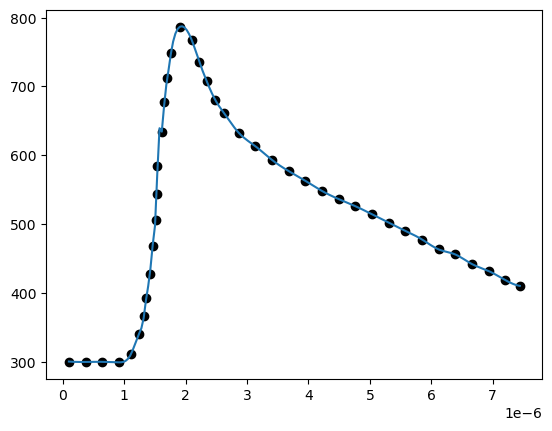

In [113]:
# define boundary conditions

# interpolate bc spline
from scipy.interpolate import make_interp_spline
pside_heating_spline_interp = make_interp_spline(df_pside['time'], df_pside['temperature'], k=3)

offset = df_pside['temperature'].iloc[0] - 300
def heating_offset(t):
    return float(pside_heating_spline_interp(t)) - offset


# check that spline is reasonable
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(df_pside['time'], df_pside['temperature']-offset, color = 'black', zorder = 1)

synthetic_x = np.linspace(min(df_pside['time']), max(df_pside['time']), 200)
ax.plot(synthetic_x, [heating_offset(x) for x in synthetic_x], zorder = 2)
plt.show()

In [ ]:
# define boundary conditions

outer_bc = RowDirichletBC(spaces.V, 'outer', value = 300.0) # defines a BC for a specific ``row`` (or column) of dofs

# inner spatially and time variable BC

# gaussian width coeff
coeff = -4.0 * np.log(2.0) / heating_FWHM**2

# Center of your heating patch along the y‐axis (adjust if needed)
y_center = 0.0  

def gaussian(x, y, t):
    """
    Gaussian in y (peaks at y_center, width heating_FWHM),
    amplitude given by pside_heating_spline_interp(t).
    """
    amp = heating_offset(t)
    return (amp - ic_temp) * np.exp(coeff * (y - y_center)**2) + ic_temp
    
inner_bc = RowDirichletBC(
    spaces.V,
    'x',
    coord=mesh_xmin + d_ins_pside,
    length=heating_FWHM*2,
    value=gaussian
)

bcs = [outer_bc.bc, inner_bc.bc]

In [110]:
from dolfinx.fem.petsc import assemble_matrix

# init forms

a_form, L_form = spaces.build_variational_forms(rho_cv_fxn, k_fxn, u_n, dt)

# init system matrix
A = assemble_matrix(spaces.a_form, bcs=bcs)
A.assemble()

# init RHS vector
b = fem.petsc.create_vector(L_form)

# init solver

# Create a KSP (Krylov Subspace) solver on the same MPI communicator as A
solver = PETSc.KSP().create(A.getComm())
# Set the operator (matrix) for the solver
solver.setOperators(A)
# Use the PREONLY solver type (no Krylov iterations, direct solve)
solver.setType(PETSc.KSP.Type.PREONLY)
# Use LU factorization as the preconditioner (exact solve)
solver.getPC().setType(PETSc.PC.Type.LU)

In [111]:
# define outputs folder

import os
outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')

# init io
from io_utilities.xdmf_utils import *

save_folder = os.path.join(outputs_folder, 'test_run_1')
os.makedirs(save_folder, exist_ok=True)

xdmf = init_xdmf(spaces.mesh, save_folder, 'solution')
uh = fem.Function(spaces.V)
uh.name = 'Temperature (K)'
uh.interpolate(ic_fxn)
xdmf.write_function(uh, 0.0)

In [112]:
# timestepping loop

# update the init bcs
outer_bc.update(0.0)
inner_bc.update(0.0)

progress_interval = max(1, num_steps // 10)
for step in range(num_steps):
    t = (step+1)*dt
    inner_bc.update(t)

    # reset and assemble rhs vector
    with b.localForm() as local_b:
        local_b.set(0)
    fem.petsc.assemble_vector(b, L_form)

    # Apply lifting and BCs to RHS
    fem.petsc.apply_lifting(b, [a_form], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    # Solve linear system
    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    # Update previous solution
    u_n.x.array[:] = uh.x.array

    # Write solution at current time
    xdmf.write_function(uh, t)

    # Print progress every 10%
    if (step + 1) % progress_interval == 0 or (step + 1) == num_steps:
        percent = int((step + 1) / num_steps * 100)
        print(f"Simulation progress: {percent}% (step {step + 1}/{num_steps})")

xdmf.close()

Simulation progress: 10% (step 20/200)
Simulation progress: 20% (step 40/200)
Simulation progress: 30% (step 60/200)
Simulation progress: 40% (step 80/200)
Simulation progress: 50% (step 100/200)
Simulation progress: 60% (step 120/200)
Simulation progress: 70% (step 140/200)
Simulation progress: 80% (step 160/200)
Simulation progress: 90% (step 180/200)
Simulation progress: 100% (step 200/200)
